In [8]:
import astropy.io.fits as fits
#from lsst.eotest.fitsTools import fitsWriteto
import lsst.daf.base as dafBase
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.ip.isr as ipIsr
import lsst.pex.exceptions as pexExcept
#import lsst.eotest.image_utils as imutils
import sys
sys.path.insert(0, '/sps/lsst/CCOB/eotest/python/lsst/eotest/')
sys.path.insert(0, '/sps/lsst/CCOB/eotest/python/lsst/eotest/sensor')
from fitsTools import fitsWriteto
import image_utils as imutils
from AmplifierGeometry import makeAmplifierGeometry


In [34]:
class MaskedCCDBiasImageException(RuntimeError):
    def __init__(self, *args):
        super(MaskedCCDBiasImageException, self).__init__(*args)

class MaskedCCD(dict):
    """
    This is the main abstraction for handling CCD data in the sensor
    acceptance test scripts.  The pixel data for each segment is
    represented by a MaskedImageF object and are accessed via the
    amplifier number.  Masks can be added and manipulated separately
    by various methods.
    """
    def __init__(self, imfile, mask_files=(), bias_frame=None, applyMasks=True):
        super(MaskedCCD, self).__init__()
        self.imfile = imfile
        self.md = imutils.Metadata(imfile, 1)
        self.amp_geom = makeAmplifierGeometry(imfile)
        all_amps = imutils.allAmps(imfile)
        print all_amps
        for amp in all_amps:
            amp-=1
            image = afwImage.ImageF(imfile, imutils.dm_hdu(amp))
            mask = afwImage.Mask(image.getDimensions())
            self[amp] = afwImage.MaskedImageF(image, mask)
        self._added_mask_types = []
        for mask_file in mask_files:
            self.add_masks(mask_file)
        self.stat_ctrl = afwMath.StatisticsControl()
        if mask_files:
            self.setAllMasks()
        if bias_frame is not None:
            self.bias_frame = MaskedCCD(bias_frame)
        else:
            self.bias_frame = None
        self._applyMasks = applyMasks
        
    def applyInterpolateFromMask(self, maskedImage, fwhm=0.001):
        for maskName in self._added_mask_types:
            try:
                ipIsr.interpolateFromMask(maskedImage, fwhm=fwhm,
                                          maskName=maskName)
            except pexExcept.InvalidParameterError:
                pass
    def mask_plane_dict(self):
        amp = self.keys()[0]
        return dict(self[amp].getMask().getMaskPlaneDict().items())
    def add_masks(self, mask_file):
        """
        Add a masks from a mask file by or-ing with existing masks.
        """
        md = imutils.Metadata(mask_file, 1)
        self._added_mask_types.append(md('MASKTYPE'))
        for amp in self:
            curr_mask = self[amp].getMask()
            curr_mask |= afwImage.MaskU(mask_file, imutils.dm_hdu(amp))
    def setMask(self, mask_name=None, clear=False):
        """
        Enable a mask and return the afwMath.StatisticsControl object
        for use by afwMath.makeStatistics. If clear is False, then the
        new mask is or'd with the existing mask.  If clear is False
        and mask_name is None, then all mask bits are cleared.
        """
        if clear:                         # Unset all masks.
            self.stat_ctrl.setAndMask(0)
        if mask_name is not None:         # Set the desired mask.
            new_mask = (self.stat_ctrl.getAndMask()
                        | afwImage.MaskU.getPlaneBitMask(mask_name))
            self.stat_ctrl.setAndMask(new_mask)
        return self.stat_ctrl
    def setAllMasks(self):
        "Enable all masks."
        mpd = self.mask_plane_dict()
        mask_bits = 2**len(mpd) - 1
        self.stat_ctrl.setAndMask(mask_bits)
        return self.stat_ctrl

    def bias_image_using_overscan(self, amp, overscan=None, fit_order=1):
        if overscan is None:
            overscan = self.amp_geom.serial_overscan
        try:
            return imutils.bias_image(self[amp], overscan=overscan,
                                      fit_order=fit_order)
        except pexExcept.LSST_RUNTIME_EXCEPTION as eobj:
            raise MaskedCCDBiasImageException("DM stack error generating bias "
                                              + "image from overscan region:\n"
                                              + str(eobj))

    def bias_image(self, amp, overscan=None, fit_order=1):
        """
        Use separately stored metadata to determine file-specified
        overscan region.
        """
        if self.bias_frame is not None:
            #
            # Use bias frame, if available, instead of overscan region
            #
            return self.bias_frame[amp].getImage()
        return self.bias_image_using_overscan(amp, overscan=overscan,
                                              fit_order=fit_order)

    def bias_subtracted_image(self, amp, overscan=None, fit_order=1):
        if self.bias_frame is not None:
            # Make a deep copy of the bias frame.
            bias = self.bias_frame[amp].Factory(self.bias_frame[amp])
            # Subtract x-independent component using overscan.
            bias -= \
                self.bias_frame.bias_image_using_overscan(amp,
                                                          overscan=overscan,
                                                          fit_order=fit_order)
            # Subtract x-independent component of image for this amp
            # using overscan.
            self[amp] -= \
                self.bias_image_using_overscan(amp, overscan=overscan,
                                               fit_order=fit_order)
            # Subtract structured, x-dependent part.
            self[amp] -= bias
        else:
            self[amp] -= self.bias_image(amp, overscan, fit_order)
        return self[amp]

    def unbiased_and_trimmed_image(self, amp, overscan=None,
                                   imaging=None, fit_order=1):
        unbiased_image = self.bias_subtracted_image(amp, overscan, fit_order)
        if imaging is None:
            imaging = self.amp_geom.imaging
        mi = imutils.trim(unbiased_image, imaging)
        if self._applyMasks:
            self.applyInterpolateFromMask(mi)
        return mi

def add_mask_files(mask_files, outfile, clobber=True):
    amp_list = imutils.allAmps(mask_files[0])
    masks = dict([(amp, afwImage.MaskU(mask_files[0], imutils.dm_hdu(amp)))
                  for amp in amp_list])
    for mask_file in mask_files[1:]:
        for amp in masks:
            masks[amp] |= afwImage.MaskU(mask_file, imutils.dm_hdu(amp))
    output = fits.HDUList()
    output.append(fits.PrimaryHDU())
    output[0].header['MASKTYPE'] = 'SUMMED_MASKS'
    fitsWriteto(output, outfile, clobber=clobber)
    for amp in masks:
        md = dafBase.PropertySet()
        md.set('EXTNAME', 'SEGMENT%s' % imutils.channelIds[amp])
        masks[amp].writeFits(outfile, md, 'a')
    return masks

def compute_stats(image, sctrl, weights=None):
    flags = afwMath.MEAN | afwMath.STDEV
    if weights is None:
        stats = afwMath.makeStatistics(image, flags, sctrl)
    else:
        stats = afwMath.makeStatistics(image, weights, flags, sctrl)
    return stats.getValue(afwMath.MEAN), stats.getValue(afwMath.STDEV)



In [35]:
import glob

ledcurrent = '_0.01A'
exptime = '_0.1s'
ccd1 = '11'
ccd2 = '10'
ccd3 = '12'
led = 'red'

dirname1 = '/sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_0_0/'
dirname2 = '/sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_0_42/'
dirname3 = '/sps/lsst/data/ccombet/CCOB/data_slac_1711/171117/testccob/xy_0_-42/'

filename_base = ccd1 + '_CCOB_' + led + ledcurrent + exptime
l = glob.glob(dirname1+filename_base+'*')
file1 = l[0]
filename_base = ccd2 + '_CCOB_' + led + ledcurrent + exptime
l = glob.glob(dirname2+filename_base+'*')
file2 = l[0]
filename_base = ccd3 + '_CCOB_' + led + ledcurrent + exptime
l = glob.glob(dirname3+filename_base+'*')
file3 = l[0]

ccd = MaskedCCD(file1)
 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


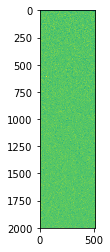

In [62]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
kk = ccd.unbiased_and_trimmed_image(1)
kk.getArrays()[0]
plt.imshow(kk.getArrays()[0])

array([[ 25469.,  25611.,  25521., ...,  24999.,  25015.,  25001.],
       [ 25472.,  25473.,  25416., ...,  25019.,  25015.,  25026.],
       [ 25464.,  25469.,  25427., ...,  25009.,  25028.,  25013.],
       ..., 
       [ 25463.,  25448.,  25365., ...,  25020.,  25020.,  25013.],
       [ 25466.,  25423.,  25376., ...,  25003.,  25015.,  25010.],
       [ 25464.,  25445.,  25368., ...,  25029.,  25001.,  25007.]], dtype=float32)